### Дисбаланс выборки

In [16]:
# Загрузка необходимых библиотек

import numpy as np #для матричных вычислений
import pandas as pd #для обработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений

# Устанавливаем стиль визуализаций в matplotlib
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [17]:
#Первичный анализ дата-сета
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


#### Визуализируем дисбаланс выборки

In [18]:
display(water_data['Potability'].value_counts(normalize=True)) #количество объектов класса 0 и 1 в процентах
# 61%
# 39%

0    0.60989
1    0.39011
Name: Potability, dtype: float64

<Axes: xlabel='Potability', ylabel='count'>

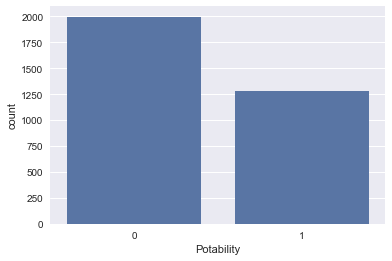

In [19]:
# визуализиреум количество объектов по классам
sns.countplot(data=water_data, x='Potability')

#### Стратифицированное разбиение

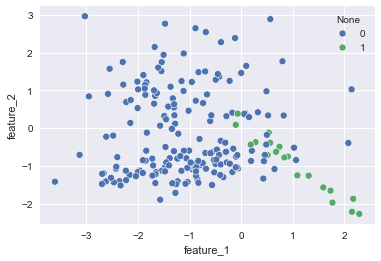

In [20]:
# генерируем датасет и произведен стратифицированное разбиение на выборки
from sklearn import datasets

X, y = datasets.make_classification(
    n_samples=200, # количество объектов в датасете
    n_features=2, #количество признаков всего в датасете
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количестов классов в датасете
    weights=[1,0.2], #пропорции классов
    random_state=40
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

<Axes: xlabel='feature_1', ylabel='feature_2'>

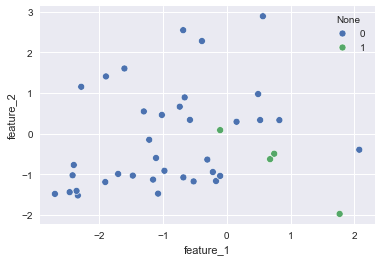

In [21]:
# Разбиваем датасет на выборки со стратификацией по y
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# визуализируем валидационную выборку X
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid)

<Axes: xlabel='feature_1', ylabel='feature_2'>

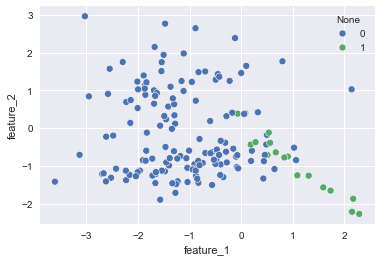

In [22]:
# Разбиваем датасет на выборки со стратификацией по y
#X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# визуализируем тренировочную выборку X
sns.scatterplot(x=X_train['feature_1'], y=X_train['feature_2'], hue=y_train)

#### МЕТРИКИ

#### Задание 3.5
Обучить модель логистической регрессии на тренировочной выборке (все параметры по умолчанию).<br>
Сделать предсказание для валидационной выборки и рассчитать метрики классификации. Ответ округлить до двух знаков после точки-разделителя.

In [23]:
from sklearn import linear_model

Визулизируем модель через созданную функцию plot_probabilities_2d()<br>
Данная функция принимает три аргумента:
- X — матрица с наблюдениями,
- y — столбец с правильными ответами,
- model — модель, с помощью которой делается предсказание вероятностей

In [24]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (15, 8))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

In [25]:
# создаем объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)

# обучаем модель, минимизируем logloss
log_reg_2d.fit(X_train, y_train)

# делаем предсказание на валидационной выборке
y_predict = log_reg_2d.predict(X_valid)

In [26]:
# возвращаем метрики
print(metrics.classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


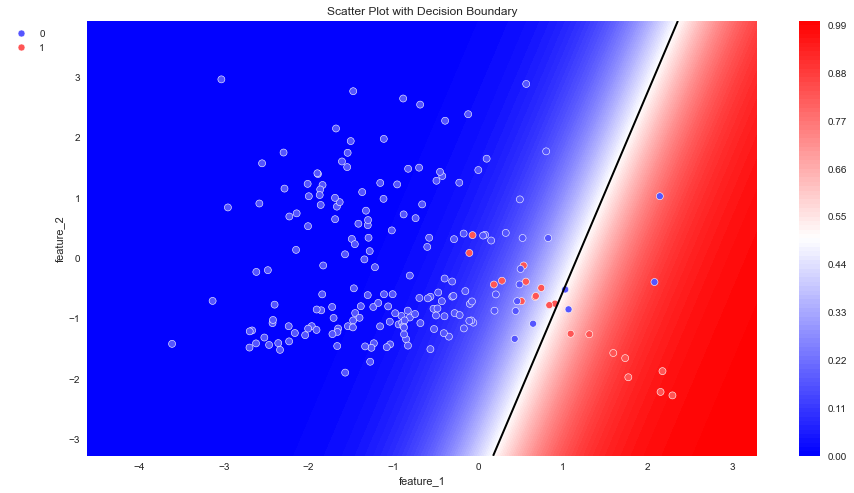

In [27]:
# визуализируем модель
plot_probabilities_2d(X, y, log_reg_2d)

#### Решение дисбалансов классов в выборке при обучении модели

In [28]:
# создаем объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(
    random_state=42,
    class_weight='balanced'
    )

# обучаем модель, минимизируем logloss
log_reg_2d.fit(X_train, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = log_reg_2d.predict(X_train)
y_valid_pred = log_reg_2d.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


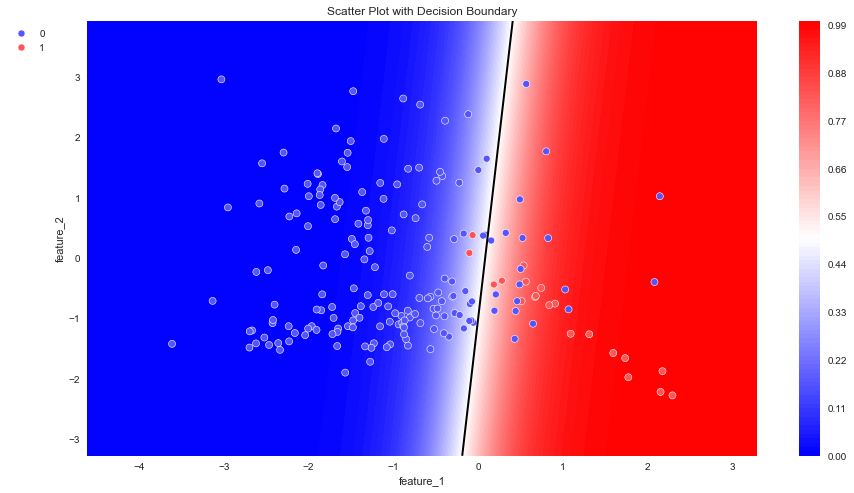

In [29]:
# визуализируем модель после взвешивания объектов
plot_probabilities_2d(X, y, log_reg_2d)

In [30]:
'''
#Пример с питьевой воды 
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))
'''

"\n#Пример с питьевой воды \n#Создаём модель\nmodel = tree.DecisionTreeClassifier(\n    criterion='entropy', #критерий информативности\n    max_depth=7, #максимальная глубина\n    min_samples_leaf=5, #минимальное число объектов в листе\n    random_state=42, #генератор случайных чисел\n    class_weight='balanced' #веса классов\n)\n#Обучаем модель на тренировочной выборке\nmodel.fit(X_train, y_train)\n#Делаем предсказание для каждой из выборок\ny_train_pred = model.predict(X_train)\ny_valid_pred = model.predict(X_valid)\n#Выводим значения метрик    \nprint(metrics.classification_report(y_valid, y_valid_pred))\n"